# Simple EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # RandomForest
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from xgboost import XGBClassifier # XGBoost
from lightgbm import LGBMClassifier # LightGBM
from catboost import CatBoostClassifier # CatBoost
from sklearn.svm import SVC, LinearSVC # SVM
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.naive_bayes import GaussianNB # naive bayes

In [2]:
train = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\train.csv')
test = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\test.csv')
submission = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.shape, test.shape

((891, 12), (418, 11))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
print('train 데이터의 columns :', list(train.columns))
print('test 데이터의 columns', list(test.columns))

train 데이터의 columns : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
test 데이터의 columns ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [7]:
# null값 확인
print('Check null value of train')
print(train.isnull().sum())
print('='*30)
print('Check null value of test')
print(test.isnull().sum())

Check null value of train
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Check null value of test
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


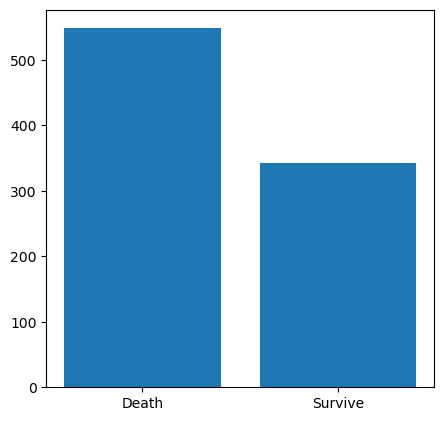

In [8]:
# label의 분포 확인
plt.figure(figsize = (5,5), dpi = 100)
plt.bar(['Death','Survive'], train['Survived'].value_counts().sort_index())
plt.show()

In [9]:
train_x = train.drop(['Survived'], axis = 1)
train_y = train['Survived']

# Preprocessing

In [10]:
# train set 전처리

train_x['Sex'] = train_x['Sex'].map({'male':0, 'female':1}) # 남자는 0, 여자는 1로 맵핑

train_x['n_of_fam'] = train_x['SibSp'] + train_x['Parch'] # 동행자수를 합한 새로운 피쳐 생성

# 혼자 탑승한 사람 수를 새로운 피쳐로 생성
train_x['Alone'] = 0 
for i in range(0, len(train_x)):
    if train_x['n_of_fam'][i] > 0:
        train_x['Alone'][i] = 0
    else:
        train_x['Alone'][i] = 1

# Name 피쳐에서 호칭에 따라 인코딩
for i in range(0, len(train_x)):
    if train_x['Name'][i].find('Mr.') != -1:
        train_x['Name'][i] = 'mr'
    elif train_x['Name'][i].find('Mrs.') != -1:
        train_x['Name'][i] = 'mrs'
    elif train_x['Name'][i].find('Miss.') != -1:
        train_x['Name'][i] = 'miss'
    elif train_x['Name'][i].find('Ms.') != -1:
        train_x['Name'][i] = 'miss'
    else:
        train_x['Name'][i] = 'other'

# Cabin 피쳐는 결측값이 너무 많으므로 해당 열을 삭제
# Ticket 피쳐는 예측 성능에 영향을 주지 않을 것으로 생각되어 삭제
train_x = train_x.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1) # Ticket과 Cabin 피쳐 삭제

In [11]:
# test set 전처리

test['Sex'] = test['Sex'].map({'male':0, 'female':1})

test['n_of_fam'] = test['SibSp'] + test['Parch']
test['Alone'] = 0
for i in range(0, len(test)):
    if test['n_of_fam'][i] > 0:
        test['Alone'][i] = 0
    else:
        test['Alone'][i] = 1

for i in range(0, len(test)):
    if test['Name'][i].find('Mr.') != -1:
        test['Name'][i] = 'mr'
    elif test['Name'][i].find('Mrs.') != -1:
        test['Name'][i] = 'mrs'
    elif test['Name'][i].find('Miss.') != -1:
        test['Name'][i] = 'miss'
    elif test['Name'][i].find('Ms.') != -1:
        test['Name'][i] = 'miss'
    else:
        test['Name'][i] = 'other'

test = test.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1)

# Missing values

In [12]:
print(train_x.isnull().sum())
print('='*20)
print(test.isnull().sum())

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
n_of_fam      0
Alone         0
dtype: int64
Pclass       0
Name         0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
n_of_fam     0
Alone        0
dtype: int64


In [13]:
# train set의 Embarked 피쳐의 유일값 개수
train_x['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
# EMbarked 피쳐의 경우 결측값이 2개만 존재
# 최빈값 정도로 채워주는 것이 적당하다.
# Embarked의 경우 0이 최빈값
train_x['Embarked'] = train_x['Embarked'].fillna('S')

In [15]:
# test set의 fare피쳐의 경우 결측값이 1개 밖에 없다.
# 무시해도 좋은 수준이기 때문에 train set의 median으로 대체해 준다.
test['Fare'] = test['Fare'].fillna(train_x['Fare'].median())

In [16]:
# 호칭별 나이의 평균값

grouped_by_name = train_x['Age'].groupby(train_x['Name'])
grouped_by_name.mean()

Name
miss     21.816327
mr       32.368090
mrs      35.898148
other    20.306066
Name: Age, dtype: float64

In [17]:
# 이름의 호칭을 나타내는 값으로 결측값을 채움

train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 'miss'),'Age']  = 22
train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 'mr'),'Age']  = 32
train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 'mrs'),'Age']  = 36
train_x.loc[ (train_x['Age'].isnull()) & (train_x['Name'] == 'other'),'Age']  = 20

test.loc[ (test['Age'].isnull()) & (test['Name'] == 'miss'),'Age']  = 22
test.loc[ (test['Age'].isnull()) & (test['Name'] == 'mr'),'Age']  = 32
test.loc[ (test['Age'].isnull()) & (test['Name'] == 'mrs'),'Age']  = 36
test.loc[ (test['Age'].isnull()) & (test['Name'] == 'other'),'Age']  = 20

In [18]:
train_x.isnull().sum() # 결측값이 모두 사라졌는지 확인

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
n_of_fam    0
Alone       0
dtype: int64

# Onehot encoding

In [19]:
train_pclass_onehot = pd.get_dummies(train_x['Pclass'], drop_first = True)
train_Embarked_onehot = pd.get_dummies(train_x['Embarked'], drop_first = True)
train_name_onehot = pd.get_dummies(train_x['Name'], drop_first = True)

test_pclass_onehot = pd.get_dummies(test['Pclass'], drop_first = True)
test_Embarked_onehot = pd.get_dummies(test['Embarked'], drop_first = True)
test_name_onehot = pd.get_dummies(test['Name'], drop_first = True)

In [20]:
train_x = pd.concat([train_x, train_pclass_onehot, train_Embarked_onehot, train_name_onehot], axis = 1)
train_x = train_x.drop(['Pclass', 'Embarked', 'Name'], axis = 1) 

test = pd.concat([test, test_pclass_onehot, test_Embarked_onehot, test_name_onehot], axis = 1)
test = test.drop(['Pclass', 'Embarked', 'Name'], axis = 1) 

In [21]:
train_x.head()

,Sex,Age,SibSp,Parch,Fare,n_of_fam,Alone,2,3,Q,S,mr,mrs,other
0,0,22.0,1,0,7.2500,1,0,0,1,0,1,1,0,0
1,1,38.0,1,0,71.2833,1,0,0,0,0,0,0,1,0
2,1,26.0,0,0,7.9250,0,1,0,1,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,1,0
4,0,35.0,0,0,8.0500,0,1,0,1,0,1,1,0,0


# Scaling

In [22]:
scaler = MinMaxScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test = scaler.transform(test)

train_y = train_y.values

# Modeling

In [23]:
# LogisticRegression GridSearchCV
params = {'penalty' : ['l2'],
          'C' : [0.001, 0.01, 0.1, 1, 10, 100],
          'max_iter' : [100, 300, 500, 1000] }
log_clf = LogisticRegression()
grid_log = GridSearchCV(log_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_log.fit(train_x, train_y)

print('best parameters : ', grid_log.best_params_)
print('best score : ', grid_log.best_score_)

log_best_model = grid_log.best_estimator_

best parameters :  {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
best score :  0.8181846713953925


In [24]:
# DecisionTreeClassifier GridSearchCV
params = {'criterion' : ['gini', 'entropy'],
          'max_depth' : [3,5,6,7,8,9,10]
         }
tree_clf = DecisionTreeClassifier()
grid_tree = GridSearchCV(tree_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_tree.fit(train_x, train_y)

print('best parameters : ', grid_tree.best_params_)
print('best score : ', grid_tree.best_score_)

tree_best_model = grid_tree.best_estimator_

best parameters :  {'criterion': 'entropy', 'max_depth': 3}
best score :  0.8181721172556651


In [25]:
# RandomForestClassifier GridSearchCV
params = {'n_estimators' : [10,50,100,200,500],
         'criterion' : ['gini', 'entropy'],
         'max_depth' : [3,5,6,7,8,9,10]
         }

rf_clf = RandomForestClassifier()
grid_rf = GridSearchCV(rf_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_rf.fit(train_x, train_y)

print('best parameters : ', grid_rf.best_params_)
print('best score : ', grid_rf.best_score_)

rf_best_model = grid_rf.best_estimator_

best parameters :  {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 10}
best score :  0.8305191136777352


In [26]:
# AdaBoostClassifier GridSearchCV
tree_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 3)

params = {'n_estimators' : [10,50,100,200,500],
          'base_estimator' : [None, tree_clf],
          'learning_rate' : [0.1, 0.01]
         }

ada_clf = AdaBoostClassifier()
grid_ada = GridSearchCV(ada_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_ada.fit(train_x, train_y)

print('best parameters : ', grid_ada.best_params_)
print('best score : ', grid_ada.best_score_)

ada_best_model = grid_ada.best_estimator_

best parameters :  {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 200}
best score :  0.8282907538760906


In [27]:
# XGBClassifier GridSearchCV
params = {'learning_rate' : [0.1, 0.01],
          'n_estimators' : [10,50,100,200,500],
          'max_depth' : [3,5,6,7,8,9,10],
         }

xgb_clf = XGBClassifier()
grid_xgb = GridSearchCV(xgb_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_xgb.fit(train_x, train_y)

print('best parameters : ', grid_xgb.best_params_)
print('best score : ', grid_xgb.best_score_)

xgb_best_model = grid_xgb.best_estimator_

[21:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [28]:
# LGBMClassifier GridSearchCV
params = {'learning_rate' : [0.1, 0.01],
          'n_estimators' : [10,50,100,200,500],
          'max_depth' : [3,5,6,7,8,9,10]
         }

lgbm_clf = LGBMClassifier()
grid_lgbm = GridSearchCV(lgbm_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_lgbm.fit(train_x, train_y)

print('best parameters : ', grid_lgbm.best_params_)
print('best score : ', grid_lgbm.best_score_)

lgbm_best_model = grid_lgbm.best_estimator_

best parameters :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
best score :  0.8428912183792606


In [29]:
# CatBoostClassifier GridSearchCV
params = {'learning_rate' : [0.1, 0.01],
          'iterations' : [10,50,100,200,500],
          'depth' : [3,5,6,7,8,9,10],
          'verbose' : [False]
         }

cat_clf = CatBoostClassifier()
grid_cat = GridSearchCV(cat_clf, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_cat.fit(train_x, train_y)

print('best parameters : ', grid_cat.best_params_)
print('best score : ', grid_cat.best_score_)

cat_best_model = grid_cat.best_estimator_

best parameters :  {'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'verbose': False}
best score :  0.8451195781809051


In [30]:
# SVC GridSearchCV
params = {'C' : [0.01, 0.1, 1, 10],
          'gamma' : ['auto'],
          'kernel' : ['rbf']
         }

svc = SVC()
grid_svc = GridSearchCV(svc, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_svc.fit(train_x, train_y)

print('best parameters : ', grid_svc.best_params_)
print('best score : ', grid_svc.best_score_)

svc_best_model = grid_svc.best_estimator_

best parameters :  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
best score :  0.8159249262444291


In [31]:
# KNeighborsClassifier GridSearchCV
params = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,13,15],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
         }

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, scoring = 'accuracy', param_grid = params, cv=5, refit = True)
grid_knn.fit(train_x, train_y)

print('best parameters : ', grid_knn.best_params_)
print('best score : ', grid_knn.best_score_)

knn_best_model = grid_knn.best_estimator_

best parameters :  {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}
best score :  0.8114556525014123


In [32]:
print('grid_log parameters : ', grid_log.best_params_)
print('grid_tree parameters : ', grid_tree.best_params_)
print('grid_rf parameters : ', grid_rf.best_params_)
print('grid_ada parameters : ', grid_ada.best_params_)
print('grid_xgb parameters : ', grid_xgb.best_params_)
print('grid_lgbm parameters : ', grid_lgbm.best_params_)
print('grid_cat parameters : ', grid_cat.best_params_)
print('grid_svc parameters : ', grid_svc.best_params_)
print('grid_knn parameters : ', grid_knn.best_params_)

grid_log parameters :  {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
grid_tree parameters :  {'criterion': 'entropy', 'max_depth': 3}
grid_rf parameters :  {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 10}
grid_ada parameters :  {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.01, 'n_estimators': 200}
grid_xgb parameters :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
grid_lgbm parameters :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
grid_cat parameters :  {'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'verbose': False}
grid_svc parameters :  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
grid_knn parameters :  {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}


In [37]:
print('grid_log score : ', grid_log.best_score_)
print('grid_tree score : ', grid_tree.best_score_)
print('grid_rf score : ', grid_rf.best_score_)
print('grid_ada score : ', grid_ada.best_score_)
print('grid_xgb score : ', grid_xgb.best_score_)
print('grid_lgbm score : ', grid_lgbm.best_score_)
print('grid_cat score : ', grid_cat.best_score_)
print('grid_svc score : ', grid_svc.best_score_)
print('grid_knn score : ', grid_knn.best_score_)

grid_log score :  0.8181846713953925
grid_tree score :  0.8181721172556651
grid_rf score :  0.8305191136777352
grid_ada score :  0.8282907538760906
grid_xgb score :  0.8473793233318687
grid_lgbm score :  0.8428912183792606
grid_cat score :  0.8451195781809051
grid_svc score :  0.8159249262444291
grid_knn score :  0.8114556525014123


In [47]:
log_clf = LogisticRegression(C = 10, max_iter = 100, penalty = 'l2')
tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
rf_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 8, n_estimators = 10)
ada_clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = 'gini', max_depth = 3),
                            learning_rate = 0.01, n_estimators = 200)
xgb_clf = XGBClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200)
lgbm_clf = LGBMClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 50)
cat_clf = CatBoostClassifier(depth = 3, iterations = 500, learning_rate = 0.1, verbose = False)
svc = SVC(C = 10, gamma = 'auto', kernel = 'rbf')
knn = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 8, weights = 'uniform')
naive_bayes = GaussianNB()

In [57]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('LogisticRegression', log_clf),
    ('DecisionTreeClassifier', tree_clf),
    ('RandomForestClassifier', rf_clf),
    ('AdaBoostClassifier', ada_clf),
    ('XGBClassifier', xgb_clf),
    ('LGBMClassifier', lgbm_clf),
    ('CatBoostClassifier', cat_clf),
    ('SVC', svc),
    ('KNeighborsClassifier', knn),
    ('naive_bayes', naive_bayes)],  
    voting='hard')

voting_model.fit(train_x, train_y)
pred = voting_model.predict(test)

[22:01:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [58]:
submission['Survived'] = 0
submission['Survived'] = pred

In [59]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [39]:
submission.to_csv(r'C:\Users\sjm\Desktop\my_Titanic_submission.csv', index=False)

# 정답확인

In [60]:
ans = pd.read_csv(r'C:\Users\sjm\Desktop\Data\kaggle\(start)Titanic_Survived_prediction\titanic_cl_answer_sheet.csv')
ans_sur = ans['Survived'].to_numpy()

In [61]:
from sklearn.metrics import accuracy_score

print(accuracy_score(ans_sur, pred))

0.7703349282296651
